# Using Scikit-Image to do Arrow Matching

In [1]:
import os
import cv2
import math 
import imutils
import json
import copy
import logging

import scipy
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

import pytesseract
from pytesseract import Output

import sklearn
from sklearn.cluster import KMeans

import skimage
from skimage import io
from skimage.util import pad
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.measure import find_contours
from skimage.util import crop as crop_skimage
from skimage.util import random_noise
from skimage.morphology import binary_closing, disk
from skimage.morphology import skeletonize as skeletonize_skimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

from scikit_arrow_utils import arrow_average, arrow_centroid, line_mag, get_orientation, get_direction
from image_utils import binary_close, binarize, binary_floodfill, skeletonize, pixel_ratio, skeletonize_area_ratio
from scikit_scripts import pad_image, segment_image, show_contours, get_image_contours

In [2]:
def split_contours(input_contours):
    ''' 
    Method to pad the contours and allow for multiple contours to be passed through 
    the pad image function one at a time. Need this method because of how weird the 
    OpenCV outputs contours 
    
    @PARAM:
        - input_contours: contours that we want to split up. Need to be at least length 1
    @RETURN:
        - if the len(input_contours) > 1, then we return a new list with contours split up
        - Else we return just return the original list for simplicity. 
    
    Note: if input_contours do not have the needed number of contours then the function will
          raise a value error. 
    '''
    if len(input_contours) == 0:
        raise ValueError("Input Contours Need at least 1 contour in them")
    elif len(input_contours) > 1:
        # Return list is the list of all contours
        return_list = []
        for cnt in input_contours:
            # New list is just compartmentalizing all the singular contours
            # Each one should have just length 1
            new_list = []
            new_list.append(cnt)
            return_list.append(new_list)
        return np.array(return_list)
    return np.array(input_contours)

In [3]:
def define_model():
    ''' 
    Function that creates the Convolutional Neural Network that we need.
    Has 6 convolutional layers, and 2 flattened layers at the end for binary
    classification. Uses a binary crossentropy loss function, and a RMSprop 
    optimizer with a learning rate of 0.001. After 8 training epochs has an accuracy of 
    0.9427. Can definitly add more contours if needed later 
    
    Summary:
    Model: "Sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    conv2d (Conv2D)              (None, 498, 498, 16)      448       
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 249, 249, 16)      0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 247, 247, 32)      4640      
    _________________________________________________________________
    max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
    _________________________________________________________________
    conv2d_2 (Conv2D)            (None, 121, 121, 64)      18496     
    _________________________________________________________________
    max_pooling2d_2 (MaxPooling2 (None, 60, 60, 64)        0         
    _________________________________________________________________
    conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
    _________________________________________________________________
    max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
    _________________________________________________________________
    conv2d_4 (Conv2D)            (None, 27, 27, 64)        36928     
    _________________________________________________________________
    max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
    _________________________________________________________________
    conv2d_5 (Conv2D)            (None, 11, 11, 64)        36928     
    _________________________________________________________________
    max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
    _________________________________________________________________
    flatten (Flatten)            (None, 1600)              0         
    _________________________________________________________________
    dense (Dense)                (None, 256)               409856    
    _________________________________________________________________
    dense_1 (Dense)              (None, 1)                 257       
    =================================================================
    Total params: 544,481
    Trainable params: 544,481
    Non-trainable params: 0
    _________________________________________________________________
    
    @RETURN: the compiled version of this model. Still needs fitting and training later 
             (8-10 epochs, should take about 20-25 min)
    
    '''
    
    model = keras.Sequential()
    # First Convolution
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(500, 500, 1)))
    model.add(MaxPooling2D((2, 2)))
    # Second Convolution
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Third Convolution 
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # The fourth convolution
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # The fifth convolution
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Sixth Convolution (Wow)
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Flatten and feed to a normal DNN
    model.add(Flatten())
    model.add(Dense(256, activation= 'relu'))
    # Gives us value between 0 and 1 for what it thinks
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Use binary crossentropy loss function to create binary classifer
    loss_fn = 'binary_crossentropy'
    opt = RMSprop(lr = 0.001)
    model.compile(optimizer = opt, loss= loss_fn, metrics=['accuracy'])
    
    return model

In [4]:
def evaluate_model(dataX, dataY, n_folds=5):
    '''
    Function that trains and evaluates a model 
    '''
    scores, histories = list(), list()
    # define model
    model = define_model()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    counter = 1
    for train_ix, test_ix in kfold.split(dataX):
        print('Beginning Fold: ' + str(counter))
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs = 5, batch_size=32, validation_data=(testX, testY), verbose=1)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=1)
        print()
        print('> %.3f' % (acc * 100.0))
        print()
        # append scores
        scores.append(acc)
        histories.append(history)
        counter += 1
    return model, scores, histories

In [87]:
def summarize_diagnostics(history):
    ''' 
    Function that takes in the history object that model.fit() throws out,
    and unpacks it to plot the Cross Entropy Loss and Accuracy of the model
    Useful to compare the Training and Validation Set
    '''
    # plot loss
    plt.subplot(211)
    plt.ylim(0, 10)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='Training Set')
    plt.plot(history.history['val_loss'], color='orange', label='Validation Set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()

    # plot accuracy
    plt.subplot(212)
    plt.ylim(0, 1.0)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='Training Set')
    plt.plot(history.history['val_accuracy'], color='orange', label='Validation Set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [65]:
def extraction(image_name = None, image = None):
    '''
    Start of extraction pipeline, from image name to printed contours and 
    an image representation of the arrows identified. Will print all necessary 
    information for the user and will allow the user to see how each image is working
    
    Steps to Pipeline:
    (1) Extract the arrow contours using find_arrow()
    (2) Find the Averages of the points on the arrow
    (3) Find the centroid (absolute middle) of the arrow
        - (2) and (3) will be used to determine direction, 
          whichever side the average is away from the centroid is the direction
          of the arrow pointing
    (4) Find the orientation of the arrow (Horizontal or Vertical)
    (5) Print all the information 
    (6) Show the image with the arrow contours 
    (7) Return the list of contours 
    
    @PARAM:
        - image_name: name of the image we want to run the pipeline on
        - image: Could also supply just loaded Cv2 image, but then dont insert
                the name of the image
                
        Examples:
        
        - If image is already loaded, use this format:
            # Loading Image 
            image = cv2.imread({whatever directory})
            extraction(image = diff_image)
            
            Note: This is preferred method, allows for image to be stored in 
            other directories and makes bulk detection easier
            
        - If you want to use the loading in the function, use this format:
            extraction(image_name = 'image.png')
            
            Note: This format is not as effective, it is better to load the images ahead 
            of time especially if doing bulk conversions
        
    @RETURN:
        - 0 if successful, 1 if there is an issue
    '''
    if image_name != None:
        try:
            image = cv2.imread(os.path.join(os.getcwd(), image_name))
        except error:
            print('Image name is not found, change directory or edit name. Function will stop now')
            return -1, -1, -1, -1, -1
    # Get the arrow contours and then get the necessary information from it
    arrow_contours = find_arrows(image)
    #If we dont find any arrows, return a message
    if len(arrow_contours) == 0:
        print("No arrows were found in the image")
        io.imshow(image)
        return -1, -1, -1, -1, -1
    print('Number of Contours: ', len(arrow_contours), '\n')
    averages = arrow_average(arrow_contours)
    centroids = arrow_centroid(arrow_contours)
    orientation = get_orientation(arrow_contours)
    direction = get_direction(arrow_contours)
#     for contour in range(len(arrow_contours)):
#         print('Arrow Contour ' + str(contour + 1) + ': \n \n', arrow_contours[contour], '\n\n')
    
    print('Arrow Average Points:', averages, '\n')
    print('Arrow Centroid Points: ', centroids, '\n')
    for i in range(len(orientation)):
        print('Arrow ' + str(i + 1) + ' Orientation: ', orientation[i])
    print()
    print(direction)
    print()
    io.imshow(show_contours(np.copy(image), arrow_contours))
    return arrow_contours
#, averages, centroids, orientation, direction

In [7]:
def pipeline(image, model):
    '''
    Full extraction pipeline, from image name to printed contours and 
    an image representation of the arrows identified. Will print all necessary 
    information for the user and will allow the user to see how each image is working
    
    Steps to Pipeline:
    (1) Extract the arrow contours using find_arrow()
    (2) Find the Averages of the points on the arrow
    (3) Find the centroid (absolute middle) of the arrow
        - (2) and (3) will be used to determine direction, 
          whichever side the average is away from the centroid is the direction
          of the arrow pointing
    (4) Find the orientation of the arrow (Horizontal or Vertical)
    (5) Print all the information 
    (6) Show the image with the arrow contours 
    (7) Return the list of contours 
    
    Steps for Final Pipeline:
    (1) Use previous pipeline to get to get all the potential arrows
    (2) Split the contours, and create padded images for them
    (3) Cache and reload them in correct format
    (4) Use the CNN to filter the potential arrows into the real arrows
    
    @PARAM:
        - image: Could also supply just loaded Cv2 image, but then dont insert
                the name of the image
        - model: Neural network that we want to use to predict. Needs to be fitted and created
                 before hand. 
                
        Examples:
        
        - If image is already loaded, use this format:
            # Loading Image 
            image = cv2.imread({whatever directory})
            pipeline(image = diff_image)
            
            Note: This is preferred method, allows for image to be stored in 
            other directories and makes bulk detection easier

    @RETURN:
        - final_contours: contours of the arrows
        - final_directions: directions of the arrows
        - final_centroids: centroids of the arrow (can be used with direction to determine reaction order)
        
        Note: Also prints these information out, and along with the original pipeline information. 
              If there are no errors from pipeline, then the function will break.
    '''
    # Because of how CNN was trained, we will save images to load into model
    # Will all be deleted later and does not adversely affect runtime
    try:
        os.makedirs('Images_Cache')
    except FileExistsError:
        os.rmdir("Images_Cache")
        os.makedirs('Images_Cache')

    cache_dir = os.path.join(os.getcwd(), 'Images_Cache')
    for i in range(len(split)):
        image = pad_image(split[i])
        io.imsave(os.path.join(cache_dir, 'testcon' + str(i + 1) + '.png'), image)
    cache = sorted(os.listdir(cache_dir))
    # Read the padded images
    padded_images = []
    for item in cache:
        item_path = os.path.join(cache_dir, item)
        read_image = cv2.imread(item_path)
        padded_images.append(read_image)
        os.remove(item_path)
    # Remove cache 
    os.rmdir("Images_Cache")
    
    # Prepare list of padded images for the model and predict
    padded_images = np.array(padded_images)
    padded_images = padded_images / 255.0
    padded_images = padded_images.reshape(padded_images.shape[0], 500, 500, 3)
    results = model.predict(padded_images)
    
    # Contours that are given a sigmoid score between 0 and 1
    # 0 is a perfect arrow and 1 is absolutly not. For now the barrier is
    # 0.1 for the barrier for the arrow. We will store the indicies in the 
    # final_contours array
    final_contours = []
    conf = []
    for contour in range(len(results)):
        if results[contour] < 0.1:
            final_contours.append(contour)
            conf.append(results[contour])
    final_centroids = []
    final_averages = []
    final_directions = []
    # Add all the information about the arrows that passed the model
    for idx in final_contours:
        final_centroids.append(centroids[idx])
        final_averages.append(averages[idx])
#         final_directions.append(direction['Arrow ' + str(idx + 1)])
    
    # Print all the logical informatio (might need to delete later)
    print()
    print("Final Contours Index: ", final_contours)
    print()
    print("Confidence: ", conf)
    print()
    print('Final Centroids', final_centroids)
    print()
    print('Final Averages', final_averages)
#     print()
#     print('Final Directions', final_directions)
    print()
    return final_contours, final_directions, final_centroids

In [8]:
# # Load all the arrows that we have and their respective contours 
# arrow_dir = os.path.join(os.getcwd(), 'arrows')
# list_arrows = sorted(os.listdir(arrow_dir))
# list_arrows = list_arrows[2:]
# arrows_contour = []
# for arrow in list_arrows:
#     arrows_image = io.imread(os.path.join(arrow_dir, arrow))
#     contours = get_image_contours(image = arrows_image)
#     arrows_contour.append(contours)

In [10]:
# im2 = io.imread(os.path.join(struct_dir, list_structs[5]))
# filled_im = segment_image(im2)
# contours = find_contours(im2, True)
# print('Number of Contours: ', print(len(contours)))
# io.imshow(filled_im)

In [11]:
custom_config = r'--oem 3 --psm 3'
custom_config2 = r'--oem 3 --psm 6'
custom_config3 = r'--oem 3 --psm 1'
custom_config4 = r'--oem 3 --psm 12'
custom_config5 = r'--oem 3 --psm 4'
custom_config6 = r'--oem 3 --psm 11'
custom_config7 = r'--oem 3 --psm 12'

In [12]:
type_arr = np.array([1, 2, 3])
type(type_arr)

numpy.ndarray

In [49]:
arrow_train = os.path.join(os.getcwd(), 'training_sets','split_training','arrows_train')
notArrow_train = os.path.join(os.getcwd(), 'training_sets','split_training','not_arrows_train')
list_arrows = sorted(os.listdir(arrow_train))[1:]
list_nots = sorted(os.listdir(notArrow_train))[1:]

training_set = []
training_labels = []

for i, arrow in enumerate(list_arrows):
    if arrow != '.ipynb_checkpoints':
        image = io.imread(os.path.join(arrow_train, arrow))
        if type(image) == type(None) or image.shape != (500, 500):
            print(arrow)
        training_set.append(image)
        training_labels.append(1)

for j, nots in enumerate(list_nots):
    if arrow != '.ipynb_checkpoints':
        image = io.imread(os.path.join(notArrow_train, nots))
        if type(image) == type(None):
            print('NoneType: ' + arrow)
        elif image.shape != (500, 500):
            print(nots + str(image.shape))
        training_set.append(image)
        training_labels.append(0)

training_set = np.array(training_set)
training_set = training_set / 255.0
training_set = training_set.reshape(len(training_set), 500, 500, 1)
training_labels = np.array(training_labels)
print(training_set.shape)
print(training_labels.shape)

(5252, 500, 500, 1)
(5252,)


In [48]:
arrow_test = os.path.join(os.getcwd(), 'training_sets','split_training','arrows_test')
notArrow_test= os.path.join(os.getcwd(), 'training_sets','split_training','not_arrows_test')
test_arrows = sorted(os.listdir(arrow_test))[1:]
test_nots = sorted(os.listdir(notArrow_test))[1:]

testing_set = []
testing_labels = []

for i, arrow in enumerate(test_arrows):
    if arrow != '.ipynb_checkpoints':
        image = io.imread(os.path.join(arrow_test, arrow))
        if type(image) == type(None) or image.shape != (500, 500):
            print(arrow)
        testing_set.append(image)
        testing_labels.append(1)

for j, nots in enumerate(test_nots):
    if arrow != '.ipynb_checkpoints':
        image = io.imread(os.path.join(notArrow_test, nots))
        if type(image) == type(None):
            print('NoneType: ' + arrow)
        elif image.shape != (500, 500):
            print(nots + str(image.shape))
        testing_set.append(image)
        testing_labels.append(0)

testing_set = np.array(testing_set)
testing_set = testing_set / 255.0
testing_set = testing_set.reshape(len(testing_set), 500, 500, 1)
testing_labels = np.array(testing_labels)
print(testing_set.shape)
print(testing_labels.shape)

(1491, 500, 500, 1)
(1491,)


In [50]:
model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 498, 498, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 58, 58, 64)       

In [51]:
history = model.fit(training_set, training_labels, epochs = 10,  validation_data=(testing_set, testing_labels), verbose=1)

Epoch 1/10
165/165 [==============================] - 427s 3s/step - loss: 0.3315 - accuracy: 0.8726 - val_loss: 1.0669 - val_accuracy: 0.6130
Epoch 2/10
165/165 [==============================] - 421s 3s/step - loss: 0.1989 - accuracy: 0.9391 - val_loss: 1.9352 - val_accuracy: 0.6351
Epoch 3/10
165/165 [==============================] - 420s 3s/step - loss: 0.1638 - accuracy: 0.9495 - val_loss: 2.0154 - val_accuracy: 0.6378
Epoch 4/10
165/165 [==============================] - 420s 3s/step - loss: 0.1399 - accuracy: 0.9568 - val_loss: 3.2965 - val_accuracy: 0.6298
Epoch 5/10
165/165 [==============================] - 419s 3s/step - loss: 0.1358 - accuracy: 0.9591 - val_loss: 3.7891 - val_accuracy: 0.6385
Epoch 6/10
165/165 [==============================] - 417s 3s/step - loss: 0.1215 - accuracy: 0.9642 - val_loss: 5.2847 - val_accuracy: 0.6459
Epoch 7/10
165/165 [==============================] - 418s 3s/step - loss: 0.1179 - accuracy: 0.9674 - val_loss: 5.7158 - val_accuracy: 0.6050

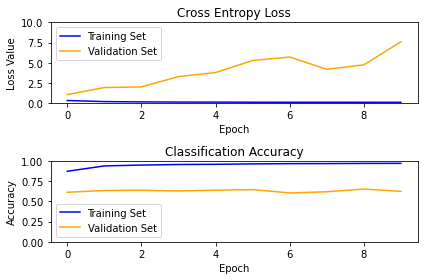

In [88]:
summarize_diagnostics(history)

In [82]:
model.save('scikit_model2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: scikit_model2/assets


In [94]:
def pipeline(image, model):
    image = segment_image(image)
    image = image.astype(float)
    print(image.shape)
    cnts1 = find_contours(image, 0)
    print(len(cnts1))
    show_contours(image, cnts1, num = -1)
    
    try:
        os.makedirs('Images_Cache')
    except FileExistsError:
        for item in os.listdir('Images_Cache'):
            os.remove(os.path.join(os.getcwd(), 'Images_Cache', item))
        os.rmdir("Images_Cache")
        os.makedirs('Images_Cache')

    cache_dir = os.path.join(os.getcwd(), 'Images_Cache')

    for i, cnt in enumerate(cnts1):
        padded = pad_image(cnts1, i)
        padded = segment_image(padded)
        io.imsave(os.path.join(cache_dir, 'testcon' + str(i).zfill(3) + '.png'), padded)
        
    cache = sorted(os.listdir(cache_dir))
    padded_images = []
    for item in cache:
        item_path = os.path.join(cache_dir, item)
        read_image = cv2.imread(item_path)
        padded_images.append(read_image)
        #os.remove(item_path)
    # Remove cache 
    #os.rmdir("Images_Cache")
    padded_images = np.array(padded_images)
    padded_images = padded_images.reshape(padded_images.shape[0], 500, 500, 3)
    results = model.predict(padded_images)
    
    final_contours = []
    conf = []
    for contour in range(len(results)):
        if results[contour] > 0.9:
            final_contours.append(contour)
            conf.append(results[contour])
    print()
    print("Final Contours Index: ", final_contours)
    print()
    print("Confidence: ", conf)
    return final_contours, conf, results

In [59]:
reactions = os.path.join(os.getcwd(), 'new_training', '1newWork')
list_reactions = sorted(os.listdir(reactions))[1:]
samples = []
for i, img in enumerate(list_reactions):
    image2 = io.imread(os.path.join(reactions, img))
    image = random_noise(image2, mode = 's&p', clip=True)
    io.imsave(os.path.join(os.getcwd(), 'new_training', 'noise_im' + img + '.png'), image)

arning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. 

In [10]:
pic = os.path.join(os.getcwd(), 'new_training', 'new_con_1690.png')
img = io.imread(pic)
print(pixel_ratio(img))

0.00244


In [36]:
test = os.path.join(os.getcwd(), 'new_test')
test_ims = sorted(os.listdir(test))[2:]
test_set = []
for i, im in enumerate(test_ims):
    img = cv2.imread(os.path.join(test, im))
    test_set.append(img)
test_set = np.array(test_set)

In [37]:
predictions = model.predict(test_set)
predictions

array([[6.0091615e-03],
       [1.0778606e-02],
       [1.5044719e-02],
       [4.4327731e-05],
       [7.3551067e-09],
       [1.0116845e-02],
       [1.6752988e-02],
       [7.8208447e-03],
       [7.9692364e-02],
       [3.9405644e-02],
       [1.6650438e-02],
       [4.5106381e-02],
       [1.1510432e-02],
       [1.9260004e-01],
       [1.5707838e-05],
       [9.9987370e-01],
       [5.3952038e-03],
       [1.4228049e-01],
       [1.5707838e-05],
       [4.7468841e-03],
       [4.7468841e-03],
       [1.5044719e-02],
       [1.5044719e-02],
       [4.7468841e-03],
       [4.2178888e-02],
       [1.2807214e-02],
       [3.2446936e-02]], dtype=float32)

testcon016.png
15[0.9998737]


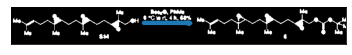

[[ 35. 366.]
 [ 35. 365.]
 [ 35. 364.]
 [ 35. 363.]
 [ 35. 362.]
 [ 34. 361.]
 [ 34. 360.]
 [ 34. 359.]
 [ 34. 358.]
 [ 34. 357.]
 [ 34. 356.]
 [ 34. 355.]
 [ 34. 354.]
 [ 34. 353.]
 [ 34. 352.]
 [ 34. 351.]
 [ 34. 350.]
 [ 34. 349.]
 [ 34. 348.]
 [ 34. 347.]
 [ 34. 346.]
 [ 34. 345.]
 [ 34. 344.]
 [ 34. 343.]
 [ 34. 342.]
 [ 34. 341.]
 [ 34. 340.]
 [ 34. 339.]
 [ 34. 338.]
 [ 34. 337.]
 [ 34. 336.]
 [ 34. 335.]
 [ 34. 334.]
 [ 34. 333.]
 [ 34. 332.]
 [ 34. 331.]
 [ 34. 330.]
 [ 34. 329.]
 [ 34. 328.]
 [ 34. 327.]
 [ 34. 326.]
 [ 34. 325.]
 [ 34. 324.]
 [ 34. 323.]
 [ 34. 322.]
 [ 34. 321.]
 [ 34. 320.]
 [ 34. 319.]
 [ 34. 318.]
 [ 34. 317.]
 [ 34. 316.]
 [ 34. 315.]
 [ 34. 314.]
 [ 34. 313.]
 [ 34. 312.]
 [ 34. 311.]
 [ 34. 310.]
 [ 34. 309.]
 [ 34. 308.]
 [ 34. 307.]
 [ 34. 306.]
 [ 34. 305.]
 [ 34. 304.]
 [ 34. 303.]
 [ 34. 302.]
 [ 34. 301.]
 [ 34. 300.]
 [ 34. 299.]
 [ 34. 298.]
 [ 34. 297.]
 [ 34. 296.]
 [ 34. 295.]
 [ 34. 294.]
 [ 34. 293.]
 [ 34. 292.]
 [ 34. 291.]
 [ 34. 290.]

In [38]:
for i, num in enumerate(predictions):
    if num > 0.9:
        print(test_ims[i])
        print(str(i) + str(num))
        show_contours(image2, cnts1, num = i + 1)
        print(cnts1[i + 1])

In [ ]:
# def box_text(test_image):
#     text_dict_rxn = pytesseract.image_to_data(test_image, output_type=Output.DICT, config=custom_config7,lang='eng')
#     n_boxes_rxn = len(text_dict_rxn['level'])
#     for i in range(n_boxes_rxn):
#         (x, y, w, h) = (text_dict_rxn['left'][i], text_dict_rxn['top'][i], text_dict_rxn['width'][i], text_dict_rxn['height'][i])
#         test_image[y: y + w, x: x + h] = 255
#     io.imshow(test_image)

In [ ]:
# box_text(image2)